In [9]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
import imageio
from PIL import Image
from skimage.registration import phase_cross_correlation
import matplotlib.animation as animation
import pylab as pl
from IPython import display
import time
from scipy.stats import poisson
import os
import sys
import importlib

In [10]:
import pyxtools.data_generator.signal_maker as fld
import pyxtools.data_generator.signals as sigs


In [11]:
importlib.reload(fld)
importlib.reload(sigs)


<module 'pyxtools.data_generator.signals' from '/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/data_generator/signals.py'>

# Define Object

In [4]:
class Obj_Params:

    array_size = (1024, 1024)
    pixel_size = (1, 1)

ObjParams = Obj_Params()

In [5]:
field1 = fld.field(
    array_size = ObjParams.array_size,  # array size of the object grid
    pixel_size = ObjParams.pixel_size
)

In [17]:
# File path
file_path =  "Analysis_codes/Fourier-Ptychography/Ptychography/images/penguin.jpeg"

In [18]:
# For penguin amplitude and vortex phase object
field1.load_signal(amp_or_pha = 'amplitude', path = file_path)
field1.make_signal(name = sigs.get_multiple_vortices, amp_or_pha = 'phase')

field1.compute_complex_field()

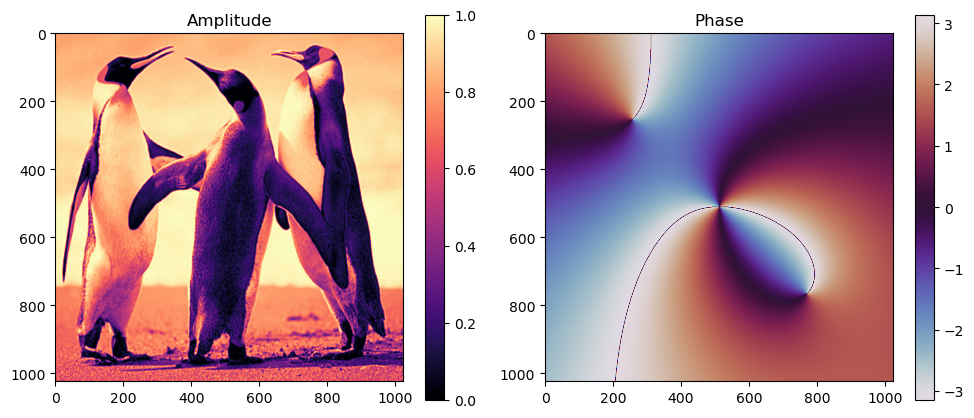

In [19]:
# Plotting the complex-signal
field1.plot_complex_field()

In [20]:
# # For the crystal amplitude and phase objects
# amplitude_path =  "/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/Files/crystal/500X_2.jpg"
# phase_path = "/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/Files/crystal/500X_DF.jpg"

In [ ]:
# # For penguin amplitude and vortex phase object
# field1.load_signal(amp_or_pha = 'amplitude', path = amplitude_path)
# field1.load_signal(amp_or_pha = 'phase', path = phase_path)


# field1.compute_complex_field()

In [ ]:
# object_gt = field1.complex_field
# print(object_gt.shape)

In [ ]:
# %matplotlib ipympl
# # Plotting the complex-signal
# field1.plot_complex_field()

## Initialization

In [21]:
sys.path.append(os.path.abspath('gpfs/cfel/user/butolama/Bragg_NF_Ptycho/'))
import pyxtools.data_generator.data_gen as fpd
import pyxtools.data_generator.improcess as imp
import pyxtools.data_generator.objects as obj
import pyxtools.data_generator.get_plot as fpp

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [22]:
# refreshes
importlib.reload(fpd)
importlib.reload(imp)
importlib.reload(obj)
importlib.reload(fpp)

<module 'pyxtools.data_generator.get_plot' from '/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/data_generator/get_plot.py'>

In [23]:
class Exp:

    wavelength = 0.63e-6 
    arraysize = 31      # array size of the LED grid
    pt_source_gap = 0.1
    source_object_distance = 90
    comp_window = 1024
    det_psize = 2.75e-6 #9.5e-9     #-----Sampling or pixel size of the CCD-----
    recon_psize = det_psize/4       #-----Final pixel size of reconstruction
    NA = 0.08 
    ground_truth_object = field1.complex_field
    
exp = Exp()


In [24]:

fpm = fpd.generate_data(
    wavelength = exp.wavelength,
    arraysize = exp.arraysize,
    pt_source_gap = exp.pt_source_gap,
    source_object_distance = exp.source_object_distance,
    comp_window = exp.comp_window,
    det_psize = exp.det_psize,
    recon_psize = exp.recon_psize,
    NA = exp.NA,
    ground_truth_object = exp.ground_truth_object
    
)

# fpm.object has the information about the object

In [25]:
fpm.pt_source_gap

0.1

## Loading Source

In [26]:
fpm.define_source()

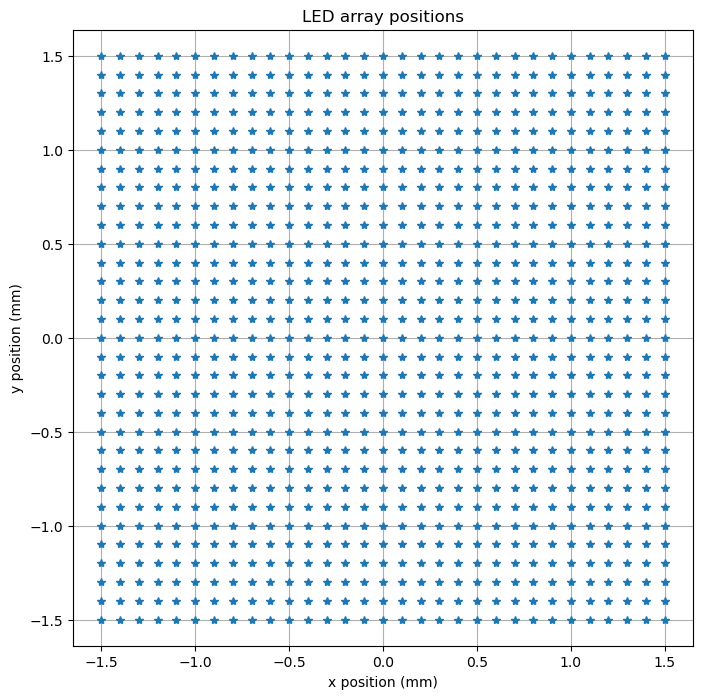

In [27]:
fpm.plot_source()

## Method 1: Generate image data -> Low resolution images of the object

In [28]:
pfile = '/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/Files/pupil_phase_test.npy'
fpm.generate_coherent_imgs_BL(pupil_path = pfile)


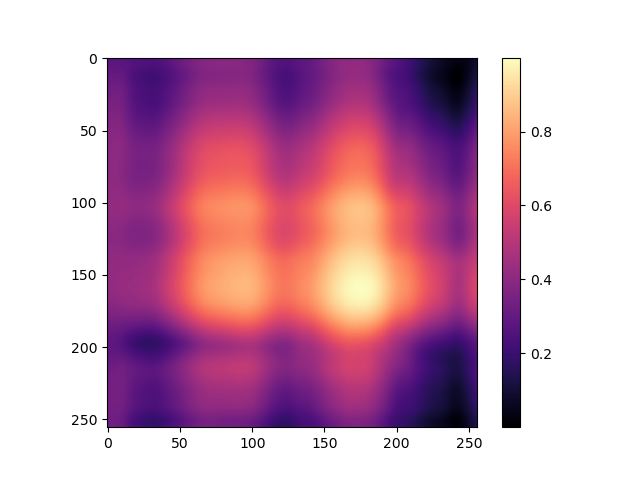

In [29]:
%matplotlib ipympl
plt.figure()
plt.imshow(np.angle(fpm.pupil), cmap = 'magma')
plt.axis('on')
plt.colorbar()

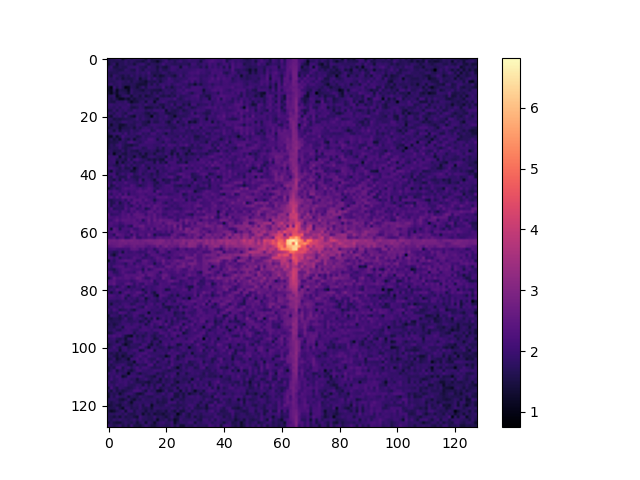

In [30]:
%matplotlib ipympl
plt.figure()
plt.imshow(np.abs(fpm.imSeqLowFT[4])**0.2, cmap = 'magma')
plt.axis('on')
plt.colorbar()

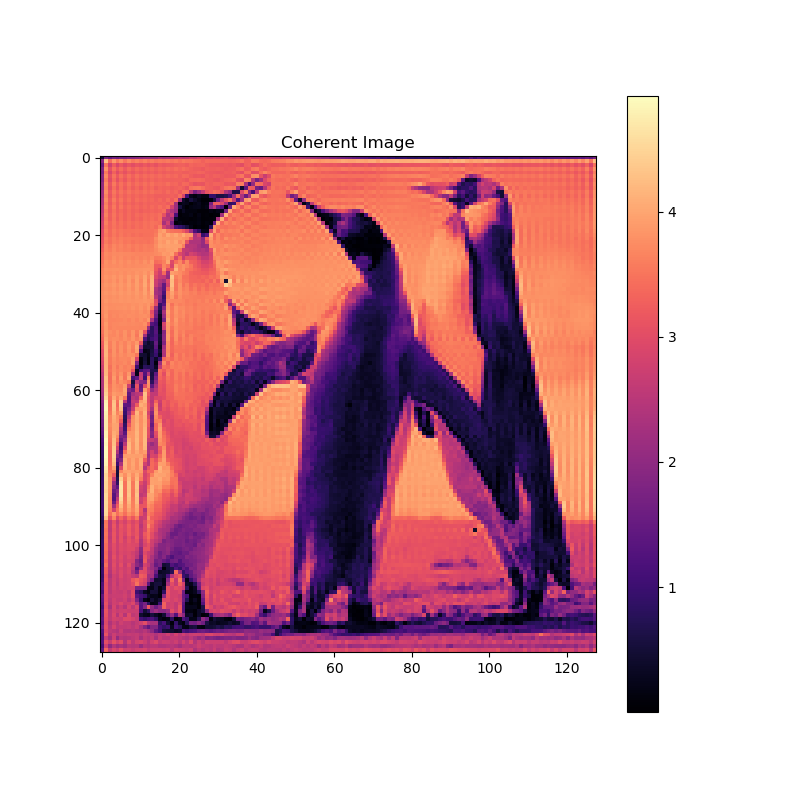

In [31]:
%matplotlib ipympl
idx = 115
fpm.plot_coherent_imgs(exp.arraysize, idx)

## Method 2: Generate Image Data -> From tilted plane wave Illumination

In [ ]:
fpm.generate_coherent_imgs_RSmodel( arraysize = exp.arraysize, recon_psize = exp.recon_psize)

In [ ]:
plt.figure()
plt.imshow(np.abs(fpm.imSeqLowRes_data[115]), cmap = 'gray')
plt.colorbar()
plt.show()

## Downsample the coherent images

In [ ]:
fpm.downsample_coherent_imgs(det_psize = exp.det_psize, DS_fac = 2)

In [ ]:
plt.figure()
plt.imshow(np.abs(fpm.DS_imSeqLowRes[200]), cmap='magma')
plt.colorbar()
plt.show()

## Image Reconstruction

### Method development and testing stage
1. EPRY
2. Optimization using JAX library
3. Optimization using pytorch

### Preparation of inputs to algorithm package

In [32]:
from pyxtools.phase_retrieval import utils_pr

In [33]:
importlib.reload(utils_pr)

<module 'pyxtools.phase_retrieval.utils_pr' from '/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/phase_retrieval/utils_pr.py'>

In [34]:
# Prepare the downsampled low-resolution Ground Truth object for comparing the TV
object_GT_DS = imp.DS_img(fpm.object, (fpm.Nds_row, fpm.Nds_col))


In [39]:
fpm.imSeqLowRes[250].shape

(128, 128)

Text(0.5, 1.0, 'Initialised Object Phase')

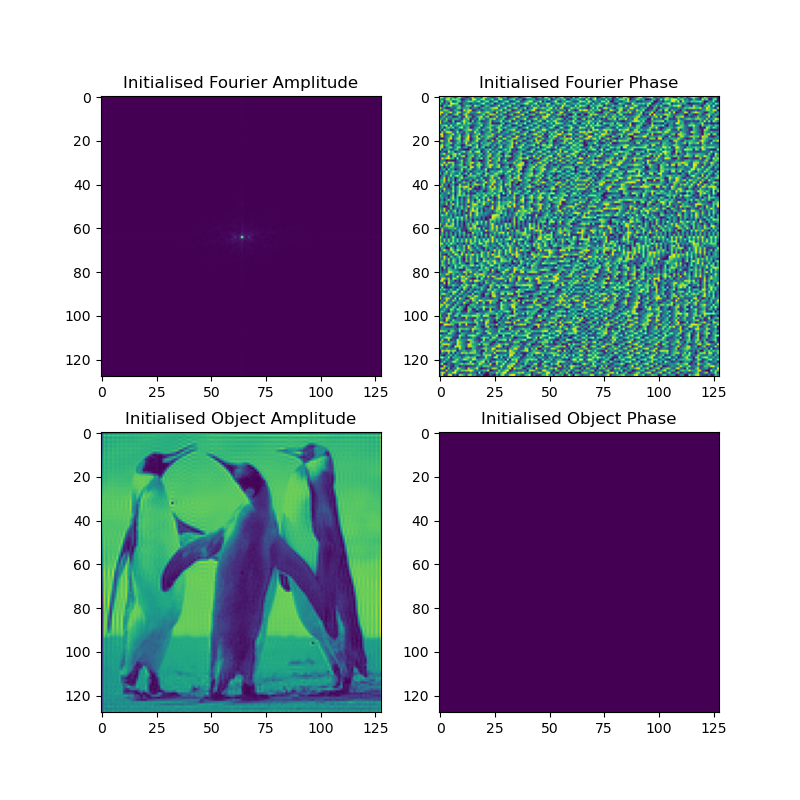

In [40]:
from numpy.fft import fftshift, ifftshift, fft2, ifft2

# Initial Guess
image_ft = fftshift(fft2(ifftshift(fpm.imSeqLowRes[250])) ) #*np.exp(1j*coh_images[0])))

init_fourier = image_ft 
init_object = fftshift(ifft2(ifftshift(init_fourier)))

fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].imshow(np.abs(init_fourier))
ax[0,0].set_title("Initialised Fourier Amplitude")
ax2 = ax[0,1].imshow(np.angle(init_fourier))

ax[0,1].set_title("Initialised Fourier Phase")
ax[1,0].imshow(np.abs(init_object))
ax[1,0].set_title("Initialised Object Amplitude")
ax[1,1].imshow(np.angle(init_object), vmin=0, vmax=1.0)
ax[1,1].set_title("Initialised Object Phase")

## EPRY

In [ ]:
# refresh 
from pyxtools.phase_retrieval import epry_class

In [ ]:
importlib.reload(epry_class)

In [ ]:
fpm.make_sequenced_images(arraysize = exp.arraysize, img_seq = fpm.imSeqLowRes )

In [ ]:
coh_images = fpm.DSimseq
kout = fpm.kout_seq
pupil_func = fpm.pupil


In [ ]:
from time import strftime
time_str = strftime("%Y-%m-%d_%H.%M")

epry_df_lr = epry_class.EPRy_lr(coh_images,  # Coherent Images
                                pupil_func = np.zeros_like(fpm.pupil), # Pupil #pfile
                                hr_fourier_image = init_fourier, # Initialised Fourier Image
                                kout_vec = kout, # Kin vectors
                                ks_pupil = fpm.kin_vec, # Pupil Kins
                                lr_psize = fpm.lr_psize, # Step Size 
                                alpha = 0.5,# For Object Spectrum update 
                                beta = 0.5) # For Pupil Function update

epry_df_lr.prepare(extend = 'double')

In [ ]:
%matplotlib ipympl
epry_df_lr.iterate(iterations=250, 
                   live_plot=True)

In [ ]:
%matplotlib ipympl
epry_df_lr.plot_rec_obj(vmin1=1,vmax1=2, vmin2 = -3, vmax2 = 3)

In [ ]:
%matplotlib ipympl

fig, ax = plt.subplots(1, 2, figsize=(9,5))
ax1 = ax[0].imshow(np.abs(epry_df_lr.hr_obj_image), cmap='magma', vmax = 1)
ax[0].axis('on')
plt.colorbar(ax1, ax=ax[0], fraction=0.046, pad=0.04)

ax2 = ax[1].imshow(np.angle(epry_df_lr.hr_obj_image), cmap='magma')
ax[1].axis('on')  
plt.colorbar(ax2, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()    

In [ ]:
%matplotlib ipympl
plt.figure()
plt.imshow(np.abs(epry_df_lr.hr_fourier_image)**0.2)
plt.colorbar()

In [ ]:
%matplotlib ipympl
plt.figure()
plt.imshow(np.angle(epry_df_lr.pupil_func), cmap = 'magma', vmin = -1e-3, vmax = 1e-3)
plt.colorbar()

## Optimization for Image Reconstruction (JAX implementation)

In [ ]:
from pyxtools.phase_retrieval import Optimization_jax

In [ ]:
importlib.reload(Optimization_jax)

In [ ]:
recons = Optimization_jax.classical_optimization(images = fpm.DS_imSeqLowRes, 
                                                pupil_func = fpm.pupil,
                                                k_out = fpm.kout,
                                                k_in = fpm.kin_vec,
                                                lr_psize = fpm.lr_psize,
                                                object_est = init_object,
                                                object_est_FT = init_fourier,
                                                object_GT = object_GT_DS)

In [ ]:
recons.optimize_object(iterations_num = 100, live_plot = True)

In [ ]:
recons.iterate(iterations_num = 100, live_plot = True)

In [ ]:
%matplotlib ipympl
recons.plot_Object_Recovery()

In [ ]:
plt.figure()
plt.imshow(np.angle(recons.obj_est), vmin = -0.1, vmax= 0.2)
plt.colorbar()

In [ ]:
%matplotlib ipympl
x_dat = np.arange(1,101,1)

plt.figure()
plt.plot(x_dat, recons.losses_tv, label = 'TV')
plt.plot(x_dat, recons._Total_Variation(object_GT_DS)*np.ones_like(x_dat), label = 'TV_GT')
plt.xlabel('iteration number')
plt.grid()
plt.legend()


In [ ]:
%matplotlib ipympl
plt.figure()
plt.plot(x_dat, recons.losses_data_fidelity)
plt.title('data Fidelity graph')
plt.xlabel('iteration number')
plt.grid()

## Optimization for Image Reconstruction (Pytorch implementation)

In [35]:
from pyxtools.phase_retrieval import optimization

In [36]:
importlib.reload(optimization)

<module 'pyxtools.phase_retrieval.optimization' from '/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/phase_retrieval/optimization.py'>

In [37]:
# Inital Guess - Pupil
print(fpm.pupil.shape)
pupil_init = np.ones_like(fpm.pupil)


(256, 256)


In [41]:
recons_opt = optimization.optim_OAP(images = fpm.imSeqLowRes, 
                                                pupil_func = pupil_init, #fpm.pupil,
                                                k_out = fpm.kout,
                                                k_in = fpm.kin_vec,
                                                lr_psize = fpm.lr_psize,
                                                object_est = init_object, #epry_df_lr.hr_obj_image, #init_object,  # Initial Object Guess
                                                object_est_FT = init_fourier,
                                                object_GT = object_GT_DS)

recons_opt.prepare(extend_pupil = 'double')

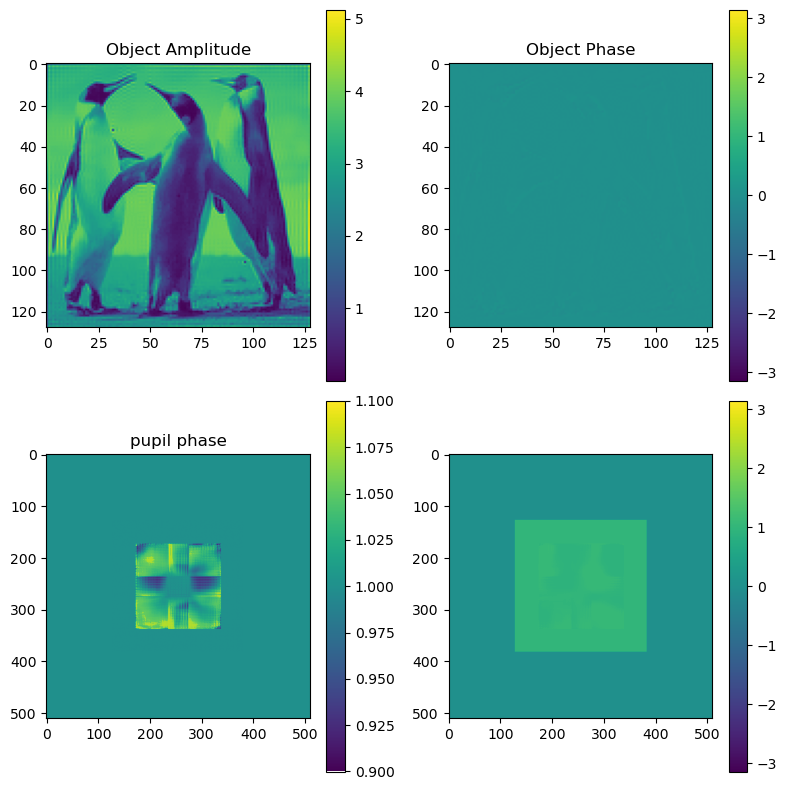

Iteration 16: Updated object
Iteration 17: Updated pupil
Iteration 18: Updated object
Iteration 19: Updated pupil


In [42]:
recons_opt.iterate(iterations_num = 20, live_plot = True, alter_iter = 2)

In [66]:
ntx, nty = recons_opt.pupil_dims

In [77]:
kx_test = np.arange(-ntx//2, ntx//2, 1)#*recons_opt.dkx

In [78]:
kxt, kyt = np.meshgrid(kx_test, kx_test)
kx_data = [kxt, kyt]

In [79]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [80]:
from pyxtools.phase_retrieval import ZernikePolynomials
from pyxtools.phase_retrieval import utils_zernike

In [81]:
pupil_phase_est = (recons_opt.pupil_phase).detach().numpy()

In [82]:
type(pupil_phase_est)

numpy.ndarray

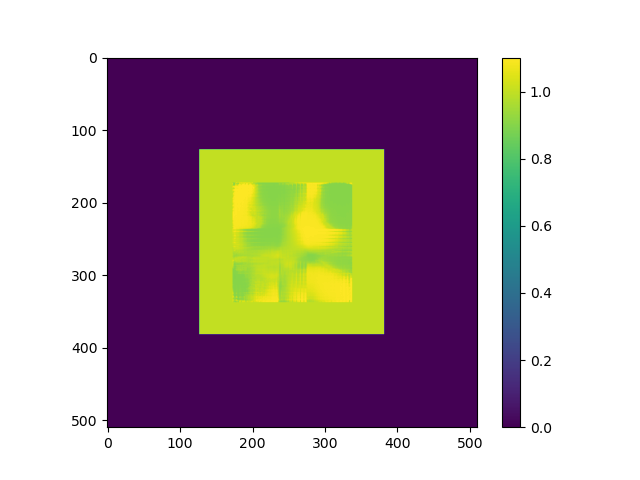

In [83]:
%matplotlib ipympl

plt.figure()
plt.imshow(pupil_phase_est)
plt.colorbar()

In [84]:
coeffs = utils_zernike.extract_square_coefficients_vectorized(pupil_phase_est)


Building design matrix...
Done


In [85]:

square_poly = SquarePolynomials() 

all_results = square_poly.evaluate_all(kx_data, coeffs)
wavefront = sum(all_results.values())


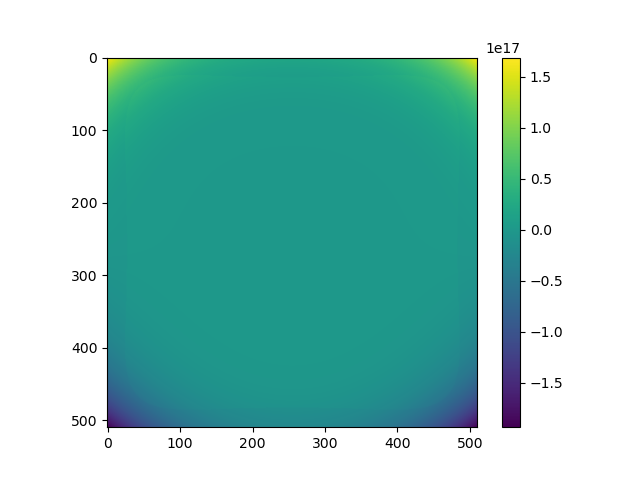

In [86]:
%matplotlib ipympl

plt.figure()
plt.imshow(wavefront)
plt.colorbar()

In [ ]:
import torch


final_object = recons_opt.final_object.detach().numpy()
pupil_function = recons_opt.final_pupil.detach().numpy()



In [ ]:
%matplotlib ipympl

fig, ax = plt.subplots(2,2, figsize=(12,8))
ax1 = ax[0, 0].imshow(np.abs(final_object), cmap = 'magma')
ax[0, 0].set_title(f"Object Amplitude")

ax2 = ax[0, 1].imshow(np.angle(final_object), vmin= -3, vmax=3, cmap = 'magma')
ax[0, 1].set_title(f"Object Phase")

ax3 = ax[1, 0].imshow(np.abs(pupil_function), cmap = 'magma')
ax[1, 0].set_title(f"Pupil Amplitude")

ax4 = ax[1, 1].imshow(np.angle(pupil_function), cmap = 'magma')
ax[1, 1].set_title(f"Pupil Phase")


plt.colorbar(ax1, ax=ax[0, 0], fraction=0.046, pad=0.04)
plt.colorbar(ax2, ax=ax[0, 1], fraction=0.046, pad=0.04)
plt.colorbar(ax3, ax=ax[1, 0], fraction=0.046, pad=0.04)
plt.colorbar(ax4, ax=ax[1, 1], fraction=0.046, pad=0.04)
plt.tight_layout()

In [ ]:
iteration_number = []
mse_loss = []
tv_val = []
for iter_k in range(200):
    iteration_number.append(recons_opt.losses_trend[iter_k]['iteration'])
    mse_loss.append(recons_opt.losses_trend[iter_k]['mse_loss']/fpm.DS_imSeqLowRes.shape[0])
    tv_val.append(recons_opt.losses_trend[iter_k]['tv_loss'])

In [ ]:


fig, ax = plt.subplots(1, 2, figsize=(9,5))
ax1 = ax[0].plot(iteration_number, mse_loss)
ax[0].set_xlabel('iteration number')
ax[0].set_ylabel('LSE')
ax[0].set_title(f"Error vs iterations")
ax[0].grid()

ax2 = ax[1].plot(iteration_number, tv_val)
ax[1].set_xlabel('iteration number')
ax[1].set_ylabel('TV')
ax[1].set_title(f"TV vs iterations")
ax[1].grid()

plt.tight_layout()

